# PART I:  Deep Q-learning

This notebook will guide you through the implementation of a Deep Q-learning agent using Pytorch. The agent will be trained to solve the `LunarLander-v2` environment from OpenAI Gym.

You will need to implement 3 classes:
- `DeepQNetwork` - The deep Q-network which will be used to approximate the Q-function.
- `ReplayBuffer` - The replay buffer which will be used to store past experiences.
- `Agent` - The agent that will interact with the environment and learn the Q-function.

Additionally you will need to implement a `training` function.

## Implementing a Deep Q-Network Class in PyTorch

This `DeepQNetwork` class is a basic implementation of a neural network for deep Q-learning in PyTorch. The following steps explain each component of the class:

### Class Definition and Initialization:
   - The class `DeepQNetwork` inherits from `nn.Module`, which is a base class for all neural network modules in PyTorch.
   - The constructor (`__init__`) initializes the network layers and sets up other parameters.

#### Constructor:
   - `input_dims`: The dimension of the input, corresponding to the state space size.
   - `fc1_dims` and `fc2_dims`: Dimensions of the first and second fully connected layers, respectively.
   - `n_actions`: The number of possible actions, which will be the output size of the network.

**Network description**:   
   - The netwrok is composed of three  fully connected (linear) layers: `fc1`, `fc2`, and `fc3`. Each layer transforms its input to a specific output dimension:
     - `fc1` takes `input_dims` as input and outputs `fc1_dims`.
     - `fc2` takes `fc1_dims` as input and outputs `fc2_dims`.
     - `fc3` takes `fc2_dims` as input and outputs `n_actions`, matching the number of actions in the environment.

**Device Selection**:
   - `self.device` sets the device for model computation, automatically choosing GPU if available (denoted by `'cuda:0'`) or CPU otherwise. 
   - The `self.to(self.device)` command moves the model to the specified device for efficient computation.

#### Forward Pass method:
   - The `forward` method defines the forward pass of the network, which is the calculation performed when input is passed through the network.
   - Each layer output is passed through a ReLU activation function (`F.relu()`), except the last layer, to introduce non-linearity:
     - `fc1`'s output is activated by ReLU and then passed to `fc2`.
     - `fc2`'s output is activated by ReLU and passed to `fc3`.
     - The final layer, `fc3`, outputs the Q-values for each action without an activation function, as we want raw scores for each action.

**Return Value**:
   - The forward method returns `actions`, which contains the Q-values for each possible action in the current state. The agent will use these Q-values to decide which action to take.

This structure allows the network to learn an approximation of the Q-value function by mapping each state to an action's Q-value, which is critical for the Deep Q-Learning algorithm.

In [1]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

class DeepQNetwork(nn.Module):
    def __init__(self, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        ...
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
        self.fc2 = ...
        self.fc3 = ...
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = ...
        return x

## Implementing a Replay Buffer for DQN

The `ReplayBuffer` class stores and manages experience data, enabling efficient sampling during training. Below is a breakdown of each method.

### `__init__`: Initializing the Replay Buffer
- **Purpose**: Initializes memory to store experience tuples for later use.
- **Parameters**:
  - `max_size`: Maximum number of experiences to store. Once this limit is reached, older experiences will be overwritten.
  - `input_shape`: The shape of each state vector.
  - `n_actions`: Number of possible actions (used to define action storage).

- **Memory Arrays (use standard numpy arrays)**:
  - `state_memory`: Stores the states experienced by the agent.
  - `new_state_memory`: Stores the subsequent states after actions are taken.
  - `action_memory`: Holds the actions taken by the agent.
  - `reward_memory`: Stores the rewards received for each action.
  - `terminal_memory`: Stores boolean flags to indicate terminal states, marking episode completion.
  
### `store_transition`: Adding a New Experience
- **Purpose**: Saves a new experience (state, action, reward, next state, and done flag) into the buffer.
- **Parameters**:
  - `state`, `action`, `reward`, `new_state`, `done`: Elements of a single experience tuple.
  
- **Implementation**:
  - `index`: The index where the new experience will be stored. It is calculated using `self.mem_cntr % self.mem_size` to allow cyclic memory replacement once the buffer is full.
  - Each memory array is updated with the new experience at `index`.
  - `self.mem_cntr` is incremented to keep track of the total number of experiences added.

### `get_batch`: Sampling a Batch of Experiences
- **Purpose**: Retrieves a random sample of experiences to use for training.
- **Parameters**:
  - `batch_size`: The number of experiences to sample.
  
- **Implementation**:
  - Select `batch_size` random indices between `0` and the minimum value between `self.mem_cntr` and  `self.mem_size`. These indices correspond to the stored experiences, ensuring each index is unique.
  - Returns separate arrays for `states`, `actions`, `rewards`, `new_states`, and `dones`, for these idices allowing easy batch processing in the DQN.


In [2]:
class ReplayBuffer():

    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, input_shape), dtype=np.float32)
        self.new_state_memory = ...
        
    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = ...

        self.mem_cntr += 1
    
    def get_batch(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)
        states = self.state_memory[batch]
        actions = ...

        return ...

## DQN Algorithm Overview

In the DQN algorithm, the goal is to approximate the optimal Q-value function \( Q* \) that maximizes expected cumulative rewards. Here are the main equations used in the implementation:

The Q-value of a state-action pair $(s, a)$ is updated according to:


$Q(s, a) \leftarrow Q(s, a) + \alpha \left( r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right)$

where:
- $ \alpha$ is the learning rate,
- $ r $ is the reward received after taking action \( a \) in state \( s \),
- $ \gamma $ is the discount factor, and
- $ s' $ is the next state.

In practice, DQN uses a neural network to approximate \( Q(s, a) \), and we don’t update \( Q(s, a) \) directly. Instead, we use a loss function to minimize the difference between the predicted Q-values and the target Q-values.

The target Q-value for a given state-action pair \((s, a)\) is defined as:

$q\_target = r + \gamma \max_{a'} Q\_target(s', a')$

where:
- $Q\_target$ is a target network, which is a copy of the Q-network that is periodically updated. 
- This target Q-value is used to reduce the variance and stabilize training.

## Implementing an Agent for DQN

The `Agent` class manages interactions between the environment and the neural network model, controlling the policy for action selection and training.

### `__init__`: Initializing the Agent
- **Purpose**: Initializes hyperparameters, the replay buffer, the neural network, and optimizer.
- **Parameters**:
  - `gamma`: Discount factor for future rewards.
  - `epsilon`: Initial exploration rate.
  - `lr`: Learning rate for the optimizer.
  - `input_dims`: Dimensions of the input state space.
  - `batch_size`: Number of samples used in each training step.
  - `n_actions`: Number of possible actions in the environment.
  - `max_mem_size`: Maximum size of the replay buffer.
  - `eps_end`: Minimum epsilon value to decay to.
  - `eps_dec`: Decay rate for epsilon.
  
- **Attributes**:
  - `replay_buffer`: Instance of `ReplayBuffer` to store experiences.
  - `Q_eval`: Neural network model (instance of `DeepQNetwork`) to approximate Q-values.
  - `optimizer`: Uses `Adam` optimizer to update `Q_eval`.
  - `loss`: Sets the mean squared error (MSE) as the loss function.

### `choose_action`: Action Selection Policy
- **Purpose**: Chooses an action based on epsilon-greedy policy to balance exploration and exploitation.
- **Parameters**:
  - `observation`: The current state observation from the environment.
  - `deterministic`: A flag to indicate whether to choose the action deterministically (used during testing).
  
- **Implementation**:
  - If a randomly generated number is greater than `epsilon`, it selects the action with the highest Q-value using `Q_eval`.
  - Otherwise, it selects a random action from `action_space`.
- **Return**: The selected action.

### `learn`: Training the Q-Network
- **Purpose**: Trains the `Q_eval` network using experiences sampled from the `replay_buffer`.
- **Implementation**:
  - **Check Replay Buffer**: Returns immediately if there are not enough samples in the replay buffer (i.e., `mem_cntr < batch_size`).
  - **Zero Gradients**: Clears previous gradients with `optimizer.zero_grad()` before backpropagation.
  - **Sample Batch**: Retrieves a batch of experiences (`states`, `actions`, `rewards`, `new_states`, `dones`) from `replay_buffer`.
  - **Convert to Tensors**: Converts arrays into PyTorch tensors for GPU computation if available.
  - **Forward Pass**:
    - `q_eval`: Q-values for the current state.
    - `q_next`: Q-values for the next state using `Q_eval`, set to 0 for terminal states to prevent spurious updates.
  - **Calculate Target Q-Values**: Computes `q_target` using the reward and discounted maximum Q-value for the next state.
  - **Loss Calculation**: Computes the MSE loss between `q_target` and `q_eval`.
  - **Backpropagation**: Calls `loss.backward()` to propagate gradients and `optimizer.step()` to update network weights.
  - **Epsilon Decay**: Reduces `epsilon` by `eps_dec` after each learning step, ensuring it does not fall below `eps_end`.


In [3]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.01, eps_dec=5e-4):
        
        self.action_space = [i for i in range(self.n_actions)]
        self.gamma = gamma
        self.epsilon = ...
        

        # Set Replay Buffer
        self.replay_buffer = ..
        # Set neural network
        self.Q_eval = ...
        # Set optimizer and loss function
        self.optimizer = optim.Adam(self.Q_eval.parameters(), lr=lr)
        self.loss = nn.MSELoss()
       
    def choose_action(self, observation, deterministic=False):
        ...
        
        return action

    def learn(self):
        # If the replay contains less than the batch size, return
        if self.replay_buffer.mem_cntr < self.batch_size:
            return
        
        self.optimizer.zero_grad()
        # Get a batch from the replay buffer
        ...
        
        # Transform batch arrays to tensors
        ...
       
        # Get the Q values for the current state and the next state, set next to 0 if terminal
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        # Calculate the target Q value
        q_target = ...

        # Calculate the loss and backpropagate
        loss = self.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.optimizer.step()

        # Decrease epsilon if it is above the minimum
        ...    

## DQN Training Code

The following code trains a Deep Q-Network (DQN) agent to solve an environment using OpenAI Gym. The agent is initialized with a neural network to approximate Q-values, an epsilon-greedy exploration strategy, and a replay buffer for storing experiences.

**1. Setup**:

   - The `gymnasium` environment is created
   - An instance of `Agent` is initialized with parameters for discount factor, exploration rate, learning rate, input dimensions, batch size, and epsilon decay.


**2. Training Loop**:

   - The code runs for a set number of episodes (`n_games`), where each episode represents a complete game or interaction sequence with the environment.
   - In each episode:
     - The environment is reset, and the agent interacts with it until the episode ends.
     - The agent selects actions based on the epsilon-greedy policy and stores each experience in the replay buffer.
     - After each action, the agent's neural network is updated using a mini-batch of experiences sampled from the buffer, allowing the agent to learn effective policies over time.


**3. Tracking Performance**:

   - `scores` collects the cumulative reward for each episode, which represents the agent’s performance over time.
   - `eps_history` tracks the epsilon values, showing how exploration decreases over time as the agent learns.
   - After each episode, the average score over the last 100 episodes is printed, providing insight into the agent’s learning progress and stability.

The code progressively reduces `epsilon`, encouraging the agent to explore actions initially but shift towards exploitation as it becomes more proficient in the task. Over multiple episodes, the DQN is expected to improve performance, enabling the agent to land the spacecraft more successfully.

In [30]:
import gymnasium as gym
from matplotlib import pyplot as plt

def training(env, agent, n_games):
    scores = []
    eps_history = []
 

    for i in range(n_games):
        score = 0
        done = False
        observation, _ = env.reset()
        while not done:
            with T.no_grad():
                # Get the action from the agent
                action = ...
                # Take the action in the environment and get the next observation
                ...
                if terminated or truncated:
                    done = True
                score += reward
                # Store the transition in the replay buffer
                ...
            # Learn from the replay buffer
            agent.learn()
            observation = observation_

        # Store the score and epsilon for ploting purposes
        scores.append(score)
        eps_history.append(agent.epsilon)
        
        # Print the score and average score every 50 episodes
        avg_score = np.mean(scores[-50:])
        if (i+1) % 50 == 0:
            print('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon)

    plt.plot(scores)
    plt.show()
    plt.plot(eps_history)
    plt.show()

Try to train the agent and observe its performance in the `LunarLander-v2` environment!

episode  0 score -129.02 average score -129.02 epsilon 1.00
episode  50 score -80.68 average score -135.58 epsilon 0.78
episode  100 score 17.83 average score -93.50 epsilon 0.49
episode  150 score -0.89 average score -38.07 epsilon 0.02
episode  200 score -244.92 average score -41.96 epsilon 0.02
episode  250 score -65.47 average score -64.16 epsilon 0.02
episode  300 score -45.38 average score -40.36 epsilon 0.02
episode  350 score -8.56 average score -17.35 epsilon 0.02
episode  400 score 308.78 average score 88.52 epsilon 0.02
episode  450 score 214.22 average score 134.60 epsilon 0.02


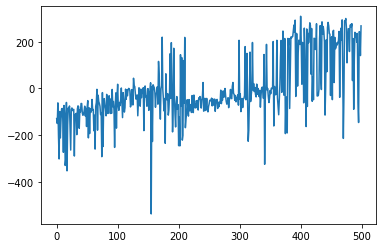

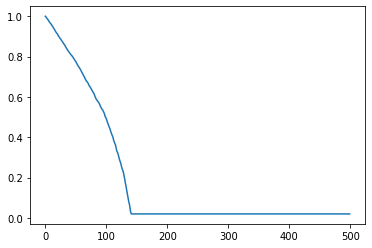

In [5]:
env = gym.make('LunarLander-v2')
agent = Agent(gamma=0.99, epsilon=1.0, lr=0.001, input_dims=8, batch_size=64, n_actions=4, eps_end=0.02, eps_dec=5e-5)
n_games = 500
training(env, agent, n_games)

## Generating and Saving an Episode GIF

This code defines a function `generate_episode` to simulate an episode in the "LunarLander-v2" environment using a deterministic policy and, if desired, captures each frame for visualization. The episode concludes when the agent reaches a terminal state, and the total reward and frames are returned.

Using the `imageio` library, the captured frames are then saved as an animated GIF. This allows for an easy visual inspection of the agent’s performance in the environment, with the option to adjust playback duration and looping. The GIF creation is particularly useful for analyzing and presenting the agent's behavior.

In [6]:
def generate_episode(env, agent, render=False): # choose an action following a deterministic policy not an epsilon greedy policy
    obs, _ = env.reset()
    frames = []
    done = False
    total_reward = 0
    while not done:
        if render:
            frames.append(env.render())
        # Choose action using policy
        a = agent.choose_action(obs, deterministic=True)
        
        # Take action and observe result
        obs_1, r, terminate, truncated, _ = env.step(a)
        total_reward += r
        # Update state
        obs = obs_1
        done = terminate or truncated
    if render:
        frames.append(env.render())
    return total_reward, frames

In [7]:
def evaluate(env, agent, n_games=100):
    total_rewards = []
    for _ in range(n_games):
        total_reward, _ = generate_episode(env, agent, render=False)
        total_rewards.append(total_reward)
    return total_rewards

In [8]:
total_rewards = evaluate(env, agent, n_games=100)
print(f'Mean total reward: {np.mean(total_rewards)} +/- {np.std(total_rewards)}')

Mean total reward: 52.34206858538122 +/- 100.01213566953489


In [9]:
# OPTINONAL: create gif of the episode
import imageio

env = gym.make('LunarLander-v2', render_mode='rgb_array')
rw, frames = generate_episode(env, agent, render=True)
imageio.mimsave('lunar_lander_basic_DQN.gif', frames, loop=0, duration=50)

# PART II: Extensions and Improvements

Next we are going to implement the following modifications:

* Add a target network
* Implement Double DQN
* Implement Dueling DQN
* Implement Prioritized Experience Replay

## Target Network Modifications

We are going to improve the Agent class by adding the target network.

The primary difference between the previous version and this one is the addition of a **target network** (`Q_target`) in the Agent class. This addition helps to stabilize the training by using two separate Q-networks: one for action selection (`Q_eval`) and one for value estimation (`Q_target`). Below are the key changes you need to make to implement this version are detailed next.




### In the `DeepQNetwork` class:

Add a method `update_weights(self, q_network, soft=True, tau=0.001)` to update the target network weights. This method will update the target network weights based on the current Q-network weights. The `soft` parameter determines whether to perform a soft update (using a weighted average) or a hard update (copying the weights directly). The `tau` parameter controls the update rate in the soft update method.

In [10]:
class DeepQNetwork(nn.Module):
    def __init__(self, input_dims, fc1_dims, fc2_dims, n_actions):
       ...

    def forward(self, state):
        ...

    def update_weights(self, q_network, soft=True, tau=0.001):
        if soft:   
            for target_param, param in zip(self.parameters(), q_network.parameters()):
                ...
        else:
            self.load_state_dict(q_network.state_dict())

### In the `Agent` class:

**1. Add the Target Network (`Q_target`)**:
   - In this version, a new network, `Q_target`, must be created as a copy of `Q_eval`.
   - After initializing `Q_target`, you need to hard-copy its weights from `Q_eval` initially.
   
**2. Modify the `learn` Method to Use `Q_target`**:
   - In the learning process, instead of using `Q_eval` for both action selection and evaluation, this version uses:
     - `Q_eval` for action selection (choosing the best action).
     - `Q_target` for action evaluation (calculating the target Q-value).
   - Therefore, the line calculating `q_next` must be updated.
   - This decoupling of selection and evaluation reduces overestimation errors in Q-learning, as the target values (`q_target`) are based on `Q_target`, which is updated less frequently.

**3. Update `Q_target` at the End of Each Learning Step**:
   - At the end of each `learn` step, call `self.Q_target.update_weights(self.Q_eval)`, using a soft update by default.
   - This ensures that `Q_target` slowly follows `Q_eval`, making the target Q-values more stable, which in turn improves the training stability.

In [11]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.01, eps_dec=5e-4):
        
        ...
        
    def choose_action(self, observation, deterministic=False):
        """Epsilon greedy policy"""

        ...

    def learn(self):
        if self.replay_buffer.mem_cntr < self.batch_size:
            return
        
        # Reset the gradients
        ...
        # Get a batch of transitions
        ...
        # Transform arrays to torch tensors
        ...
        # Get the Q values for the current state using Q and the next state using Q target, 
        # set next to 0 if terminal
        batch_index = ...
        q_eval = ...
        q_next = ...
        q_next[terminal_batch] = 0.0

        # Calculate the target Q value
        q_target = ...

        # Calculate the loss and backpropagate
        ...

        # Decrease epsilon if it is above the minimum
        ...   
        
        # Update the target network
        ...

Train again the agent using the new version of the Agent class and compare the results.

episode  0 score -194.27 average score -194.27 epsilon 1.00
episode  50 score -110.10 average score -154.83 epsilon 0.73
episode  100 score -77.60 average score -105.75 epsilon 0.02
episode  150 score -321.23 average score -121.84 epsilon 0.02
episode  200 score 193.55 average score -28.39 epsilon 0.02
episode  250 score 189.61 average score 75.63 epsilon 0.02
episode  300 score 202.75 average score 60.73 epsilon 0.02
episode  350 score 200.46 average score 133.42 epsilon 0.02
episode  400 score 258.24 average score 175.35 epsilon 0.02
episode  450 score -357.83 average score 216.65 epsilon 0.02


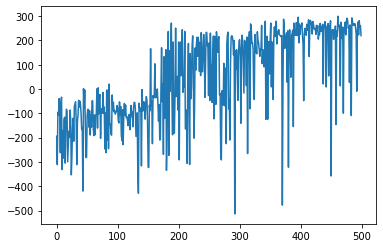

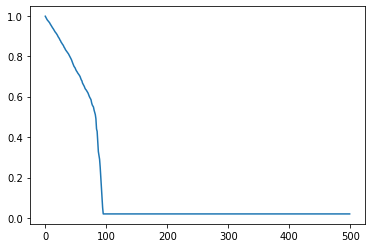

In [12]:
env = gym.make('LunarLander-v2')
agent2 = Agent(gamma=0.99, epsilon=1.0, lr=0.001, input_dims=8, batch_size=64, n_actions=4, eps_end=0.02, eps_dec=5e-5)
n_games = 500
training(env, agent2, n_games)

In [13]:
total_rewards = evaluate(env, agent2, n_games=100)
print(f'Mean total reward: {np.mean(total_rewards)} +/- {np.std(total_rewards)}')

Mean total reward: 218.92911796858988 +/- 76.73249894192776


## Doble DQN

Copy again the Agent class and modify it to implement the Double DQN algorithm.


### 1. Action Selection and Evaluation
In a standard DQN:

$q\_target = reward\_batch + \gamma \cdot \max(Q\_target(s'))$

In Double DQN:
1. Use the `Q_eval` network to select the action with the maximum value in the next state \(s'\).
2. Use the `Q_target` network to evaluate the value of this action.

The new target calculation for Double DQN is:

$q\_target = reward\_batch + \gamma \cdot Q\_target(s', \arg\max Q\_eval(s'))$

In [14]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.01, eps_dec=5e-4):
        
        ...
        
    def choose_action(self, observation, deterministic=False):
        """Epsilon greedy policy"""

        ...

    def learn(self):
        if self.replay_buffer.mem_cntr < self.batch_size:
            return
        
        # Reset the gradients
        ...

        # Get a batch of transitions
        ...
        
        # Transform arrays to torch tensors
        ...
       
        # Get the Q values for the current state using Q and the next state using Q target, 
        # set next to 0 if terminal
        batch_index = ...
        q_eval =...
        
        # Get the best action in the new_state according to Q_eval
        next_best_action = ...
 
        # In the new_state, get the Q value for the best action (decided by Q_eval) according to Q_target
        q_next = ...
        q_next[terminal_batch] = 0.0
        
        # Calculate the target Q value
        q_target = ...

        # Calculate the loss and backpropagate
        ...

        # Decrease epsilon if it is above the minimum
        ...    
        
        # Update the target network
        ...

Train again the agent using the new version of the Agent class and compare the results.

episode  0 score -332.21 average score -332.21 epsilon 1.00
episode  50 score -117.78 average score -158.44 epsilon 0.76
episode  100 score -317.76 average score -113.67 epsilon 0.32
episode  150 score -41.45 average score -42.57 epsilon 0.02
episode  200 score 165.90 average score -9.10 epsilon 0.02
episode  250 score 258.58 average score 145.71 epsilon 0.02
episode  300 score -17.60 average score 103.43 epsilon 0.02
episode  350 score 282.23 average score 189.09 epsilon 0.02
episode  400 score 287.23 average score 258.32 epsilon 0.02
episode  450 score 262.12 average score 243.73 epsilon 0.02


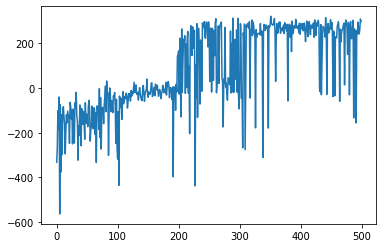

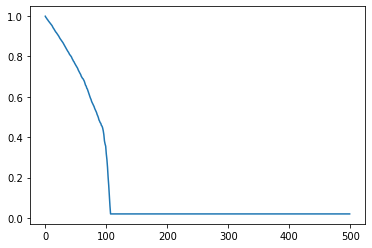

In [15]:
env = gym.make('LunarLander-v2')
agent3 = Agent(gamma=0.99, epsilon=1.0, lr=0.001, input_dims=8, batch_size=64, n_actions=4, eps_end=0.02, eps_dec=5e-5)
n_games = 500
training(env, agent3, n_games)

In [16]:
total_rewards = evaluate(env, agent3, n_games=100)
print(f'Mean total reward: {np.mean(total_rewards)} +/- {np.std(total_rewards)}')

Mean total reward: 265.4016063289956 +/- 32.15167254714595


## Dueling DQN

In **Dueling DQN**, the Q-value function $Q(s, a)$ is split into two components to improve the agent’s ability to evaluate states independently of actions:

1. **State-Value Function** $V(s)$: Represents the value of being in a state $s$, irrespective of the action.
2. **Advantage Function** $A(s, a)$: Measures the relative benefit of each action $a$ in state $s$, allowing the agent to differentiate between advantageous and disadvantageous actions.

The Q-value in Dueling DQN is calculated by combining these components:

$Q(s, a) = V(s) + \left( A(s, a) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a') \right)$

where:
- $V(s)$ is the state-value.
- $A(s, a)$ is the advantage for each action in the state.
- The advantage mean term \( \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a') \) ensures the Q-values remain stable, reducing variance.

### Modifications to the DeepQNetwork Class
Therefore to implement Dueling DQN, the only modification required is to modify the architecture of the neural network to have separate streams for estimating $V(s)$ and $A(s, a)$. The network then combines these outputs to calculate $Q(s, a)$ for each action:

1. **State-Value Stream**:
   - Add a fully connected layer that outputs $V(s)$ (a single value).

2. **Advantage Stream**:
   - Add a fully connected layer that outputs $A(s, a)$ for each action $a$ (similar to what you already have).

3. **Combining Value and Advantage**:
   - The Q-values are calculated as:
     
     $Q(s, a) = V(s) + \left( A(s, a) - \text{mean}(A(s, a')) \right)$
     
   - Here, $\text{mean}(A(s, a'))$ is the average advantage across all actions, ensuring that the Q-values are appropriately normalized and stable.

These architectural adjustments allow the network to more effectively learn the value of each state, irrespective of the chosen action, and improve performance in tasks where some actions are inconsequential in certain states.


In [17]:
class DuelingDeepQNetwork(nn.Module):
    def __init__(self, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DuelingDeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = ...
        self.fc1 = ...
        self.fc2 = ...
        self.value_stream = ...
        self.advantage_stream = ...

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = ...
        x =...
        value = ...
        advantage = ...
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

    def update_weights(self, q_network, soft=True, tau=0.001):
        ...

**WARNING!** The `choose_action` method could require some modification depending on how you compute the Q-values adding the valu function $V(s)$ and the advantage function $A(s, a)$.

In [18]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.01, eps_dec=5e-4):
        
        ...
        
    def choose_action(self, observation, deterministic=False):
        """Epsilon greedy policy"""
        # print("choose action")
        if np.random.random() > self.epsilon or deterministic:
            state = T.tensor(observation, dtype=T.float).to(self.Q_eval.device).unsqueeze(0)
            ...
        else:
            ...
        
        return action

    def learn(self):
        ...

Train again the agent using the new version of the Agent class and compare the results.

episode  0 score -200.56 average score -200.56 epsilon 1.00
episode  50 score -243.35 average score -137.64 epsilon 0.76
episode  100 score -23.12 average score -105.28 epsilon 0.40
episode  150 score -49.00 average score -81.87 epsilon 0.02
episode  200 score 99.87 average score 31.58 epsilon 0.02
episode  250 score 206.32 average score 57.95 epsilon 0.02
episode  300 score 257.45 average score 156.16 epsilon 0.02
episode  350 score -29.87 average score 66.37 epsilon 0.02
episode  400 score -175.14 average score 95.23 epsilon 0.02
episode  450 score 272.25 average score 219.45 epsilon 0.02


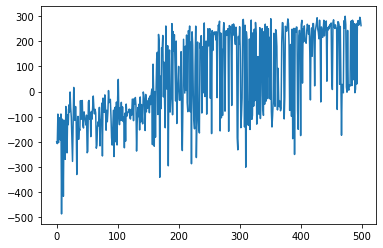

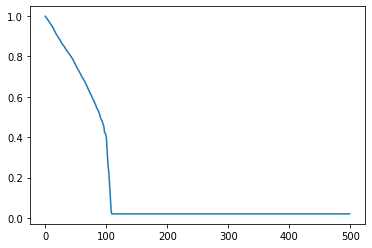

In [19]:
env = gym.make('LunarLander-v2')
agent4 = Agent(gamma=0.99, epsilon=1.0, lr=0.001, input_dims=8, batch_size=64, n_actions=4, eps_end=0.02, eps_dec=5e-5)
n_games = 500
training(env, agent4, n_games)

In [20]:
total_rewards = evaluate(env, agent4, n_games=100)
print(f'Mean total reward: {np.mean(total_rewards)} +/- {np.std(total_rewards)}')

Mean total reward: 196.86704435396032 +/- 141.3194439635015
